In [ ]:


# This downloads the COCO dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

# Network Visualization

In this notebook, we will explore the use of *image gradients* for generating new images.

When training a model, we define a loss function which measures our current unhappiness with the model's performance. We then use backpropagation to compute the gradient of the loss with respect to the model parameters and perform gradient descent on the model parameters to minimize the loss.

Here we will do something slightly different. We will start from a CNN model which has been pretrained to perform image classification on the ImageNet dataset. We will use this model to define a loss function which quantifies our current unhappiness with our image. Then we will use backpropagation to compute the gradient of this loss with respect to the pixels of the image. We will then keep the model fixed and perform gradient descent *on the image* to synthesize a new image which minimizes the loss.

We will explore three techniques for image generation.

**Saliency Maps.** We can use saliency maps to tell which part of the image influenced the classification decision made by the network.

**Fooling Images.** We can perturb an input image so that it appears the same to humans but will be misclassified by the pretrained network.

**Class Visualization.** We can synthesize an image to maximize the classification score of a particular class; this can give us some sense of what the network is looking for when it classifies images of that class.

In [1]:
# Setup cell.
import torch
import torchvision
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
from cs231n.image_utils import SQUEEZENET_MEAN, SQUEEZENET_STD
from cs231n.net_visualization_pytorch import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # Set default size of plots.
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

# Pretrained Model

For all of our image generation experiments, we will start with a convolutional neural network which was pretrained to perform image classification on ImageNet. We can use any model here, but for the purposes of this assignment we will use SqueezeNet [1], which achieves accuracies comparable to AlexNet but with a significantly reduced parameter count and computational complexity.

Using SqueezeNet rather than AlexNet or VGG or ResNet means that we can easily perform all image generation experiments on CPU.

[1] Iandola et al, "SqueezeNet: AlexNet-level accuracy with 50x fewer parameters and < 0.5MB model size", arXiv 2016

In [2]:
# Download and load the pretrained SqueezeNet model.
model = torchvision.models.squeezenet1_1(pretrained=True)

# We don't want to train the model, so tell PyTorch not to compute gradients
# with respect to model parameters.
for param in model.parameters():
    param.requires_grad = False

## Loading ImageNet Validation Images
We have provided a few example images from the validation set of the ImageNet ILSVRC 2012 Classification dataset. Since they come from the validation set, our pretrained model did not see these images during training. Run the following cell to visualize some of these images along with their ground-truth labels.

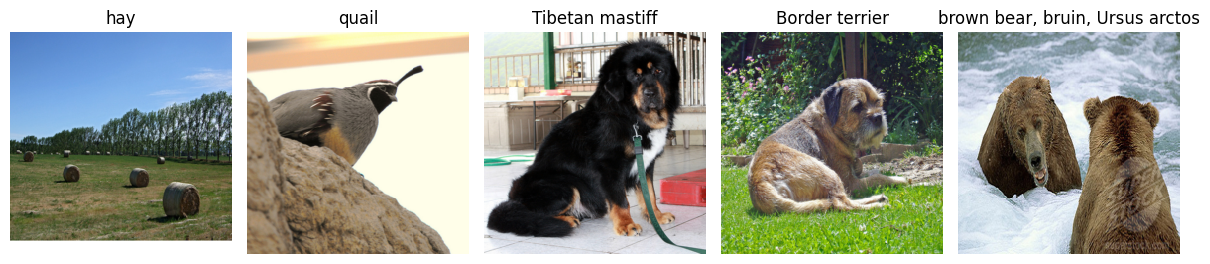

In [3]:
from cs231n.data_utils import load_imagenet_val
X, y, class_names = load_imagenet_val(num=5)

plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X[i])
    plt.title(class_names[y[i]])
    plt.axis('off')
plt.gcf().tight_layout()

# Saliency Maps
Using this pretrained model, we will compute class saliency maps as described in Section 3.1 of [2].

A **saliency map** tells us the degree to which each pixel in the image affects the classification score for that image. To compute it, we compute the gradient of the unnormalized score corresponding to the correct class (which is a scalar) with respect to the pixels of the image. If the image has shape `(3, H, W)` then this gradient will also have shape `(3, H, W)`; for each pixel in the image, this gradient tells us the amount by which the classification score will change if the pixel changes by a small amount. To compute the saliency map, we take the absolute value of this gradient, then take the maximum value over the 3 input channels; the final saliency map thus has shape `(H, W)` and all entries are nonnegative.

[2] Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman. "Deep Inside Convolutional Networks: Visualising
Image Classification Models and Saliency Maps", ICLR Workshop 2014.

### Hint: PyTorch `gather` method
Recall in Assignment 1 you needed to select one element from each row of a matrix; if `s` is an numpy array of shape `(N, C)` and `y` is a numpy array of shape `(N,`) containing integers `0 <= y[i] < C`, then `s[np.arange(N), y]` is a numpy array of shape `(N,)` which selects one element from each element in `s` using the indices in `y`.

In PyTorch you can perform the same operation using the `gather()` method. If `s` is a PyTorch Tensor of shape `(N, C)` and `y` is a PyTorch Tensor of shape `(N,)` containing longs in the range `0 <= y[i] < C`, then

`s.gather(1, y.view(-1, 1)).squeeze()`

will be a PyTorch Tensor of shape `(N,)` containing one entry from each row of `s`, selected according to the indices in `y`.

run the following cell to see an example.

You can also read the documentation for [the gather method](http://pytorch.org/docs/torch.html#torch.gather)
and [the squeeze method](http://pytorch.org/docs/torch.html#torch.squeeze).

In [4]:
# Example of using gather to select one entry from each row in PyTorch
def gather_example():
    N, C = 4, 5
    s = torch.randn(N, C)
    y = torch.LongTensor([1, 2, 1, 3])
    print(s)
    print(y)
    print(s.gather(1, y.view(-1, 1)).squeeze())
gather_example()

tensor([[ 1.4107, -0.2536, -0.2598,  0.6851,  0.4314],
        [ 2.3981, -0.1987, -1.5380,  1.8961, -0.4339],
        [ 1.9192,  0.8734,  0.7723,  0.5974,  1.1905],
        [ 1.9510, -0.5028,  1.9747, -1.5391, -0.0150]])
tensor([1, 2, 1, 3])
tensor([-0.2536, -1.5380,  0.8734, -1.5391])


Implement ```compute_saliency_maps``` function inside ```cs231n/net_visualization_pytorch.py```

Once you have completed the implementation above, run the following to visualize some class saliency maps on our example images from the ImageNet validation set:

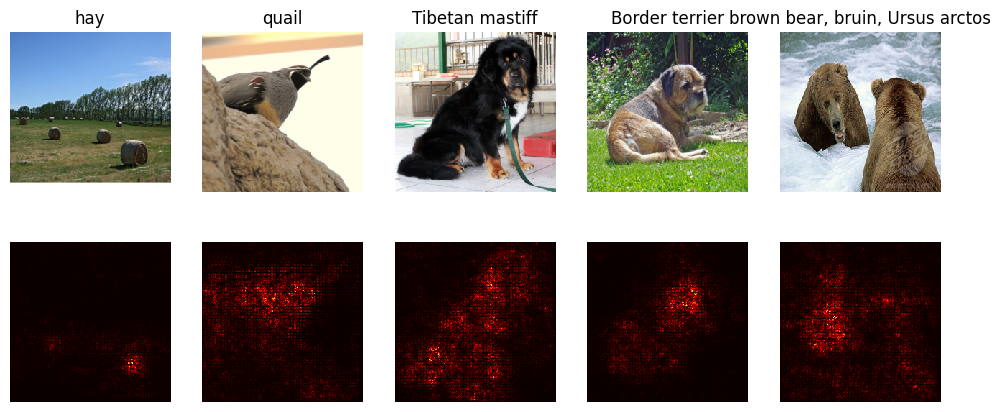

In [5]:
def show_saliency_maps(X, y):
    # Convert X and y from numpy arrays to Torch Tensors
    X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
    y_tensor = torch.LongTensor(y)

    # Compute saliency maps for images in X
    saliency = compute_saliency_maps(X_tensor, y_tensor, model)

    # Convert the saliency map from Torch Tensor to numpy array and show images
    # and saliency maps together.
    saliency = saliency.numpy()
    N = X.shape[0]
    for i in range(N):
        plt.subplot(2, N, i + 1)
        plt.imshow(X[i])
        plt.axis('off')
        plt.title(class_names[y[i]])
        plt.subplot(2, N, N + i + 1)
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(12, 5)
    plt.show()

show_saliency_maps(X, y)

# Inline Question 1

A friend of yours suggests that in order to find an image that maximizes the correct score, we can perform gradient ascent on the input image, but instead of the gradient we can actually use the saliency map in each step to update the image. Is this assertion true? Why or why not?

**Your Answer:** 

No. Because we took the absolute value of the gradient when caculating the saliency map. This step causes loss of gradient directions.

# Fooling Images
We can also use image gradients to generate "fooling images" as discussed in [3]. Given an image and a target class, we can perform gradient **ascent** over the image to maximize the target class, stopping when the network classifies the image as the target class. Implement the following function to generate fooling images.

[3] Szegedy et al, "Intriguing properties of neural networks", ICLR 2014

Implement ```make_fooling_image``` function inside ```cs231n/net_visualization_pytorch.py```

Run the following cell to generate a fooling image. You should ideally see at first glance no major difference between the original and fooling images, and the network should now make an incorrect prediction on the fooling one. However you should see a bit of random noise if you look at the 10x magnified difference between the original and fooling images. Feel free to change the `idx` variable to explore other images.

In [6]:
idx = 0
target_y = 6

X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
X_fooling = make_fooling_image(X_tensor[idx:idx+1], target_y, model)

scores = model(X_fooling)
assert target_y == scores.data.max(1)[1][0].item(), 'The model is not fooled!'

Iteration: 0  dif: 18.917736053466797
Iteration: 1  dif: 18.770214080810547
Iteration: 2  dif: 17.993885040283203
Iteration: 3  dif: 16.91560173034668
Iteration: 4  dif: 15.582113265991211
Iteration: 5  dif: 14.302386283874512
Iteration: 6  dif: 13.053079605102539
Iteration: 7  dif: 11.916349411010742
Iteration: 8  dif: 10.813701629638672
Iteration: 9  dif: 9.548221588134766
Iteration: 10  dif: 8.33583927154541
Iteration: 11  dif: 7.087717056274414
Iteration: 12  dif: 6.460575103759766
Iteration: 13  dif: 5.772743225097656
Iteration: 14  dif: 5.37244987487793
Iteration: 15  dif: 5.13359260559082
Iteration: 16  dif: 4.874120712280273
Iteration: 17  dif: 4.516017913818359
Iteration: 18  dif: 4.088584899902344
Iteration: 19  dif: 3.6703739166259766
Iteration: 20  dif: 3.248231887817383
Iteration: 21  dif: 2.730531692504883
Iteration: 22  dif: 2.2537612915039062
Iteration: 23  dif: 1.844747543334961
Iteration: 24  dif: 1.517629623413086
Iteration: 25  dif: 1.1435527801513672
Iteration: 26 

After generating a fooling image, run the following cell to visualize the original image, the fooling image, as well as the difference between them.

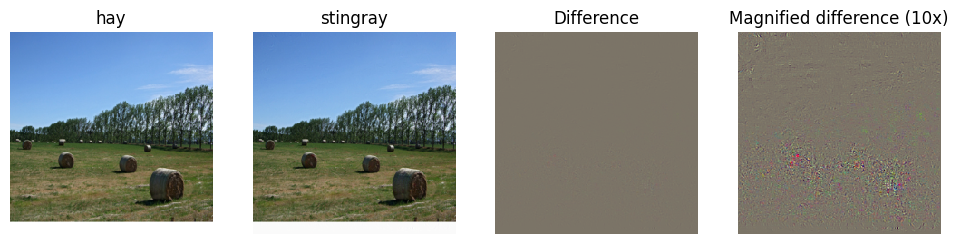

In [7]:
X_fooling_np = deprocess(X_fooling.clone())
X_fooling_np = np.asarray(X_fooling_np).astype(np.uint8)

plt.subplot(1, 4, 1)
plt.imshow(X[idx])
plt.title(class_names[y[idx]])
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(X_fooling_np)
plt.title(class_names[target_y])
plt.axis('off')

plt.subplot(1, 4, 3)
X_pre = preprocess(Image.fromarray(X[idx]))
diff = np.asarray(deprocess(X_fooling - X_pre, should_rescale=False))
plt.imshow(diff)
plt.title('Difference')
plt.axis('off')

plt.subplot(1, 4, 4)
diff = np.asarray(deprocess(10 * (X_fooling - X_pre), should_rescale=False))
plt.imshow(diff)
plt.title('Magnified difference (10x)')
plt.axis('off')

plt.gcf().set_size_inches(12, 5)
plt.show()

# Class Visualization
By starting with a random noise image and performing gradient ascent on a target class, we can generate an image that the network will recognize as the target class. This idea was first presented in [2]; [3] extended this idea by suggesting several regularization techniques that can improve the quality of the generated image.

Concretely, let $I$ be an image and let $y$ be a target class. Let $s_y(I)$ be the score that a convolutional network assigns to the image $I$ for class $y$; note that these are raw unnormalized scores, not class probabilities. We wish to generate an image $I^*$ that achieves a high score for the class $y$ by solving the problem

$$
I^* = \arg\max_I (s_y(I) - R(I))
$$

where $R$ is a (possibly implicit) regularizer (note the sign of $R(I)$ in the argmax: we want to minimize this regularization term). We can solve this optimization problem using gradient ascent, computing gradients with respect to the generated image. We will use (explicit) L2 regularization of the form

$$
R(I) = \lambda \|I\|_2^2
$$

**and** implicit regularization as suggested by [3] by periodically blurring the generated image. We can solve this problem using gradient ascent on the generated image.

[2] Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman. "Deep Inside Convolutional Networks: Visualising
Image Classification Models and Saliency Maps", ICLR Workshop 2014.

[3] Yosinski et al, "Understanding Neural Networks Through Deep Visualization", ICML 2015 Deep Learning Workshop

In `cs231n/net_visualization_pytorch.py` complete the implementation of the `class_visualization_update_step` used in the `create_class_visualization` function below.
Once you have completed that implementation, run the following cells to generate an image of a Tarantula:

In [8]:
def create_class_visualization(target_y, model, dtype, **kwargs):
    """
    Generate an image to maximize the score of target_y under a pretrained model.

    Inputs:
    - target_y: Integer in the range [0, 1000) giving the index of the class
    - model: A pretrained CNN that will be used to generate the image
    - dtype: Torch datatype to use for computations

    Keyword arguments:
    - l2_reg: Strength of L2 regularization on the image
    - learning_rate: How big of a step to take
    - num_iterations: How many iterations to use
    - blur_every: How often to blur the image as an implicit regularizer
    - max_jitter: How much to gjitter the image as an implicit regularizer
    - show_every: How often to show the intermediate result
    """
    model.type(dtype)
    l2_reg = kwargs.pop('l2_reg', 1e-3)
    learning_rate = kwargs.pop('learning_rate', 25)
    num_iterations = kwargs.pop('num_iterations', 100)
    blur_every = kwargs.pop('blur_every', 10)
    max_jitter = kwargs.pop('max_jitter', 16)
    show_every = kwargs.pop('show_every', 25)

    # Randomly initialize the image as a PyTorch Tensor, and make it requires gradient.
    img = torch.randn(1, 3, 224, 224).mul_(1.0).type(dtype).requires_grad_()

    for t in range(num_iterations):
        # Randomly jitter the image a bit; this gives slightly nicer results
        ox, oy = random.randint(0, max_jitter), random.randint(0, max_jitter)
        img.data.copy_(jitter(img.data, ox, oy))
        class_visualization_update_step(img, model, target_y, l2_reg, learning_rate)
        # Undo the random jitter
        img.data.copy_(jitter(img.data, -ox, -oy))

        # As regularizer, clamp and periodically blur the image
        for c in range(3):
            lo = float(-SQUEEZENET_MEAN[c] / SQUEEZENET_STD[c])
            hi = float((1.0 - SQUEEZENET_MEAN[c]) / SQUEEZENET_STD[c])
            img.data[:, c].clamp_(min=lo, max=hi)
        if t % blur_every == 0:
            blur_image(img.data, sigma=0.5)

        # Periodically show the image
        if t == 0 or (t + 1) % show_every == 0 or t == num_iterations - 1:
            plt.imshow(deprocess(img.data.clone().cpu()))
            class_name = class_names[target_y]
            plt.title('%s\nIteration %d / %d' % (class_name, t + 1, num_iterations))
            plt.gcf().set_size_inches(4, 4)
            plt.axis('off')
            plt.show()

    return deprocess(img.data.cpu())

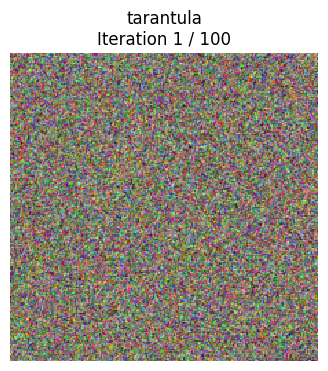

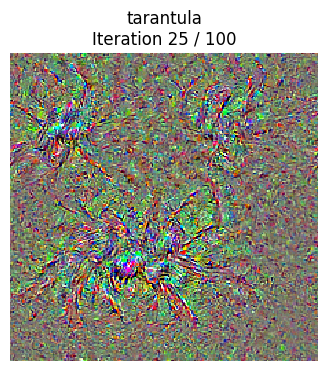

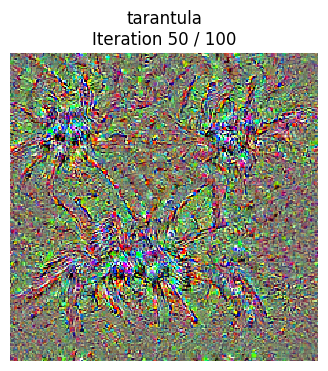

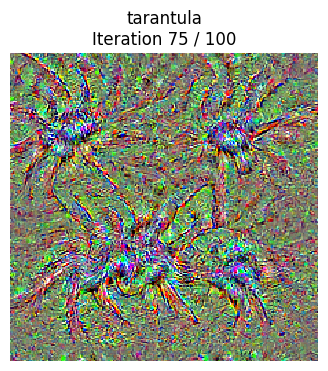

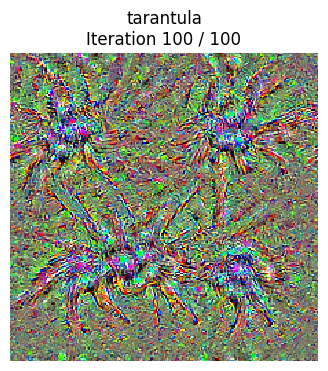

In [9]:
dtype = torch.FloatTensor
model.type(dtype)

target_y = 76 # Tarantula
# target_y = 78 # Tick
# target_y = 187 # Yorkshire Terrier
# target_y = 683 # Oboe
# target_y = 366 # Gorilla
# target_y = 604 # Hourglass
out = create_class_visualization(target_y, model, dtype)

Try out your class visualization on other classes! You should also feel free to play with various hyperparameters to try and improve the quality of the generated image, but this is not required.

sarong


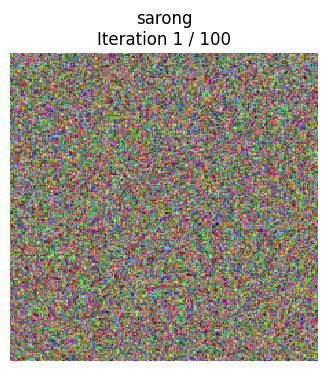

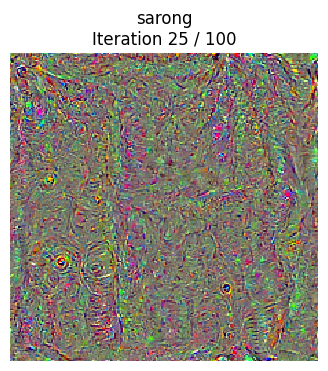

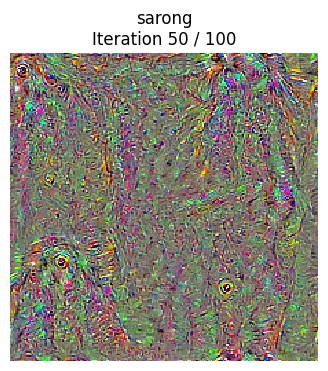

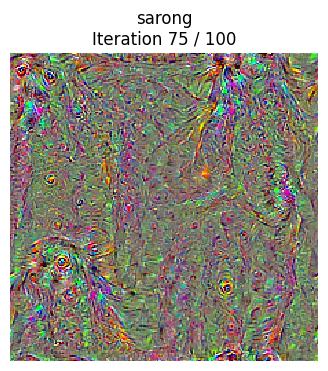

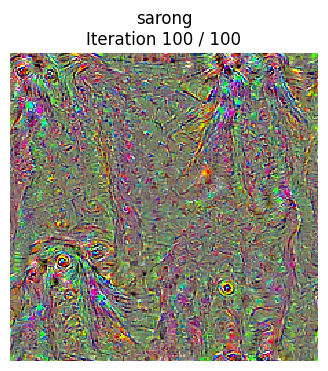

In [10]:
# target_y = 78 # Tick
# target_y = 187 # Yorkshire Terrier
# target_y = 683 # Oboe
# target_y = 366 # Gorilla
# target_y = 604 # Hourglass
target_y = np.random.randint(1000)
print(class_names[target_y])
X = create_class_visualization(target_y, model, dtype)